In [22]:
import torch
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import transformers
import numpy as np
from os import path
import pandas as pd
from transformers import AutoTokenizer, TFXLNetModel, TFAutoModel, TFXLNetForSequenceClassification
from constants import *
import dataset_utils as du
from new_model import create_model, create_model_no_stackx

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from training_metrics import TrainMetrics
from evaluation_metrics import EvalMetrics
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
TRAIN_RATIO = .6
DEV_RATIO = .2
LEARNING_RATE = 0.000001 
BATCH_SIZE = 3
EPOCHS = 2

In [4]:
# Uncomment the following line to rerun pre-processing and tokenization
# du.prepare_and_save(RAW_DATASET_PATH, path.join(PROCESSED_DIR, PROCESSED_DATASET))

data = pd.read_pickle(path.join(PROCESSED_DIR, PROCESSED_DATASET))
interest = du.get_interest_dataset(data)
comprehension = du.get_comprehension_dataset(data)
comprehension = du.get_balanced_dataset(comprehension, 'comprehension_binary', random_state=1)
comprehension = comprehension.sample(frac=1, random_state=1)


/home/ubuntu/kevin/Question-Classifier/dataset_utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interest['interest_binary'] = (interest['interest'] > 3).astype(int)
/home/ubuntu/kevin/Question-Classifier/dataset_utils.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comprehension['comprehension_binary'] = (comprehension['comprehension'] > 3).astype(int)


In [5]:
# K-fold split
features = du.get_features(comprehension)
labels = du.get_labels(comprehension, 'comprehension_binary')
folds = du.kfold_split(features, labels, num_folds=8)

# Alternate to k-fold split: manually split

train_set, dev_set, test_set = du.split_datasets(comprehension, .2, DEV_RATIO)
train_features, train_labels = du.get_features(train_set), du.get_labels(train_set, 'comprehension_binary')
dev_features, dev_labels = du.get_features(dev_set), du.get_labels(dev_set, 'comprehension_binary')
test_features, test_labels = du.get_features(test_set), du.get_labels(test_set, 'comprehension_binary')

In [6]:
du.get_balance(train_labels)

{0: 322, 1: 326, 'percent_pos': 0.5030864197530864}

In [7]:
keras.backend.clear_session()
model = create_model(MAX_LEN, NUM_SX_FEATURES)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-5,
    decay_steps=50,
    decay_rate=0.9,
    staircase=True
)

model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary', 'logits_proj']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
# import os
# os.mkdir('saved_model_weights/v1')
# model.save_weights('saved_model_weights/v1/snapshot1')

In [9]:
# keras.utils.plot_model(model)

In [10]:
training_metrics = TrainMetrics('testmodel1', epochs=EPOCHS)
hist = model.fit(train_features, train_labels, validation_split=.1,batch_size=3, epochs=3, shuffle=True, callbacks=[training_metrics])

Epoch 1/3
195/195 [==============================] - 188s 881ms/step - loss: 0.7111 - accuracy: 0.5169 - val_loss: 0.7172 - val_accuracy: 0.4923
Epoch 2/3
195/195 [==============================] - 169s 865ms/step - loss: 0.7143 - accuracy: 0.5069 - val_loss: 0.7170 - val_accuracy: 0.5077
Epoch 3/3
195/195 [==============================] - 169s 865ms/step - loss: 0.7156 - accuracy: 0.4726 - val_loss: 0.7167 - val_accuracy: 0.5077


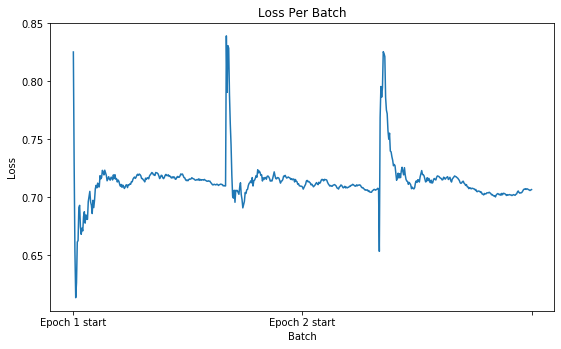

Saved training metrics to testmodel1-train.json
Loaded training metrics from testmodel1-train.json


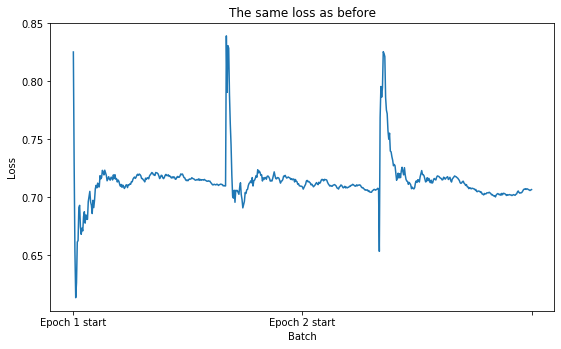

In [11]:
training_metrics.plot_loss()
training_metrics.save_metrics_json()
reloaded_train_metrics = TrainMetrics('testmodel1', load_json=True)
reloaded_train_metrics.plot_loss(title='The same loss as before', save_image=True)

In [ ]:
# model.evaluate(dev_features, dev_labels, batch_size=BATCH_SIZE)

In [ ]:
#model.save('model_checkpoints/dev62pct')

In [ ]:
dev_preds = model.predict(dev_features, batch_size=BATCH_SIZE)

In [48]:
del EvalMetrics
class EvalMetrics:

################################ Public Interface ################################

    def __init__(self, model_name, dataset={}, load_json=False):
        self.model_name = f'{model_name}-eval'
        self.json_file = f'{self.model_name}.json'
        if load_json:
            with open(self.json_file, 'r') as f:
                data = json.load(f)
                self.feats = [np.array(feat) for feat in data['feats']]
                self.preds = np.array(data['preds'])
                self.labels = np.array(data['labels'])
            print(f'Loaded evaluation metrics from {self.json_file}')
        else:
            self.feats = dataset['feats']
            self.preds = dataset['preds']
            self.labels = dataset['labels']

        self.cr = classification_report(self.labels, self.preds, output_dict=True)

    def get_accuracy(self):
        return self.cr['accuracy']

    def get_f1score(self, avg_type='weighted avg'):
        return self.cr[avg_type]['f1-score']

    def get_precision(self, avg_type='weighted avg'):
        return self.cr[avg_type]['precision']

    def get_recall(self, avg_type='weighted avg'):
        return self.cr[avg_type]['recall']

    def get_classification_report(self):
        """
        Returns a dictionary of metrics.
        For example:
        {
            '0': {
                'precision': 0.6,
                'recall': 0.07780979827089338,
                'f1-score': 0.1377551020408163,
                'support': 347
            },
            '1': {
                'precision': 0.4693200663349917,
                'recall': 0.9401993355481728,
                'f1-score': 0.6261061946902655,
                'support': 301
            },
            'accuracy': 0.4783950617283951,
            'macro avg': {
                'precision': 0.5346600331674958,
                'recall': 0.5090045669095331,
                'f1-score': 0.3819306483655409,
                'support': 648
            },
            'weighted avg': {
                'precision': 0.5392983641463465,
                'recall': 0.4783950617283951,
                'f1-score': 0.3645971990894031,
                'support': 648
            }
        }
        where '0' is the class representing no comprehension and '1' is the
        class representing comprehension.
        """
        return self.cr

    def print_classification_report(self):
        print(classification_report(self.labels, self.preds))

    def plot_confusion_matrix(self, title='Confusion Matrix', save_image=False):
        cm = confusion_matrix(self.labels, self.preds)
        df_cm = pd.DataFrame(cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
        sn.set(font_scale=1.4)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}).set_title(title)
        if save_image:
            plt.savefig(f'{self.model_name}-cm.png')
        plt.show()

    def save_metrics_json(self):
        data = {
            'feats': [feat.tolist() for feat in self.feats],
            'preds': self.preds.tolist(),
            'labels': self.labels.tolist()
        }
        with open(self.json_file, 'w') as f:
            json.dump(data, f)
        print(f'Saved evaluation metrics to {self.json_file}')

################################################################################



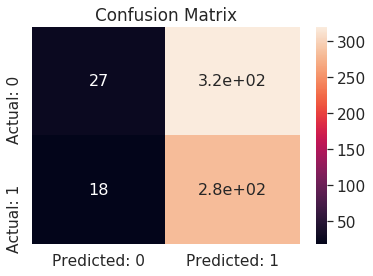

Saved evaluation metrics to testmodel2-eval.json
Loaded evaluation metrics from testmodel2-eval.json


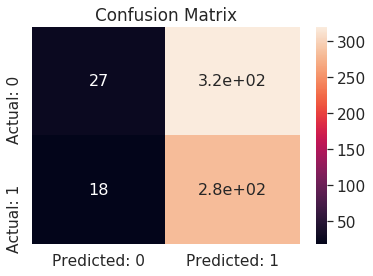

              precision    recall  f1-score   support

           0       0.60      0.08      0.14       347
           1       0.47      0.94      0.63       301

    accuracy                           0.48       648
   macro avg       0.53      0.51      0.38       648
weighted avg       0.54      0.48      0.36       648

0.3645971990894031


In [49]:
# dev_preds = model.predict(dev_features, batch_size=BATCH_SIZE)
dev_preds = np.rint(dev_preds).astype(int)
eval_dataset = {'feats': dev_features, 'labels': dev_labels, 'preds': dev_preds}
eval_metrics = EvalMetrics('testmodel2', eval_dataset)
eval_metrics.plot_confusion_matrix()
eval_metrics.save_metrics_json()
reloaded_eval_metrics = EvalMetrics('testmodel2', {}, load_json=True)
reloaded_eval_metrics.plot_confusion_matrix(save_image=True)
reloaded_eval_metrics.print_classification_report()
print(reloaded_eval_metrics.get_f1score())

In [43]:
pos = np.where(dev_preds >= .5)
neg = np.where(dev_preds < .5)
print(f'Positives: {pos[0].shape[0]}')
print(f'Negatives: {neg[0].shape[0]}')
dev_preds = np.rint(dev_preds).astype(int)
print(np.sum(dev_preds))

Positives: 603
Negatives: 45
603
